<a href="https://colab.research.google.com/github/Stanley487/Data-Science/blob/main/tweet_Nike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Packages**

 The required versions of scipy and the wordcloud library are installed for later text processing and visualizations.

In [1]:
!pip install numpy==1.24.4  # Compatible with Python 3.11
!pip install scipy
!pip install pandas
!pip install wordcloud
!pip install gensim
!pip install nltk
!pip install matplotlib
!pip install seaborn

**Importing Libraries**

Import essential libraries for data manipulation, text processing, sentiment analysis, topic modeling, and visualization.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

**Downloading NLTK Data**

Required datasets such as punkt, stopwords, and vader_lexicon are downloaded to ensure that text processing and sentiment analysis work smoothly.



In [3]:
# Ensure necessary NLTK data packages are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

**Data Loading**

In [4]:
# Load the dataset
# Replace the file path with your local file path if necessary.
df = pd.read_csv('justdoit_tweets_2018_09_07.csv')

In [5]:
# Inspect the first few rows to understand the dataset structure
print("Dataset preview:")
print(df.head())

Dataset preview:
   tweet_contributors                                  tweet_coordinates  \
0                 NaN                                                NaN   
1                 NaN                                                NaN   
2                 NaN                                                NaN   
3                 NaN  {'type': 'Point', 'coordinates': [-86.45594032...   
4                 NaN                                                NaN   

                 tweet_created_at tweet_display_text_range  \
0  Fri Sep 07 16:25:06 +0000 2018                  [0, 75]   
1  Fri Sep 07 16:24:59 +0000 2018                 [0, 237]   
2  Fri Sep 07 16:24:50 +0000 2018                 [0, 176]   
3  Fri Sep 07 16:24:44 +0000 2018                  [0, 88]   
4  Fri Sep 07 16:24:39 +0000 2018                 [0, 132]   

                                      tweet_entities  \
0  {'hashtags': [{'text': 'quote', 'indices': [47...   
1  {'hashtags': [{'text': 'hero', 'indice

**Data Cleaning and Preprocessing**  

 The data is cleaned using a preprocessing function that removes URLs, mentions, hashtags, and non-alphanumeric characters, then converts the text to lowercase to prepare it for tokenization and further analysis

In [6]:
# Assuming the tweet text is in a column named 'text'
#if 'text' not in df.columns:
#   raise ValueError("Expected a 'text' column in the dataset.")
# Check if the tweet text column exists
if 'tweet_full_text' not in df.columns:
    raise ValueError("Expected a 'tweet_full_text' column in the dataset.")

# Rename it to 'text' for consistency in the rest of your code
df.rename(columns={'tweet_full_text': 'text'}, inplace=True)



In [7]:
def clean_text(text):
    """
    Clean the tweet text by:
    - Removing URLs
    - Removing mentions (e.g., @user)
    - Removing the '#' symbol from hashtags
    - Removing non-alphanumeric characters (punctuation)
    - Converting text to lowercase
    """
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#', '', text)     # remove hashtag symbols
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # remove punctuation and special characters
    text = text.lower()  # normalize to lowercase
    return text

In [8]:
# Apply the cleaning function to the tweet texts
df['clean_text'] = df['text'].apply(clean_text)

**Tokenization and Stopword Removal**

In [9]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# Tokenize the cleaned text and remove stopwords
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    """
    Tokenize the text and remove common stopwords.
    Also, filter out tokens with less than 3 characters.
    """
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

df['tokens'] = df['clean_text'].apply(tokenize_text)

**Sentiment Analysis using VADER**

In [11]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER to obtain sentiment scores for each tweet
df['sentiment_scores'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x))
df['compound_score'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])

# Classify sentiment based on compound score thresholds:
# Positive if compound > 0.05, Negative if compound < -0.05, else Neutral
def classify_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['compound_score'].apply(classify_sentiment)

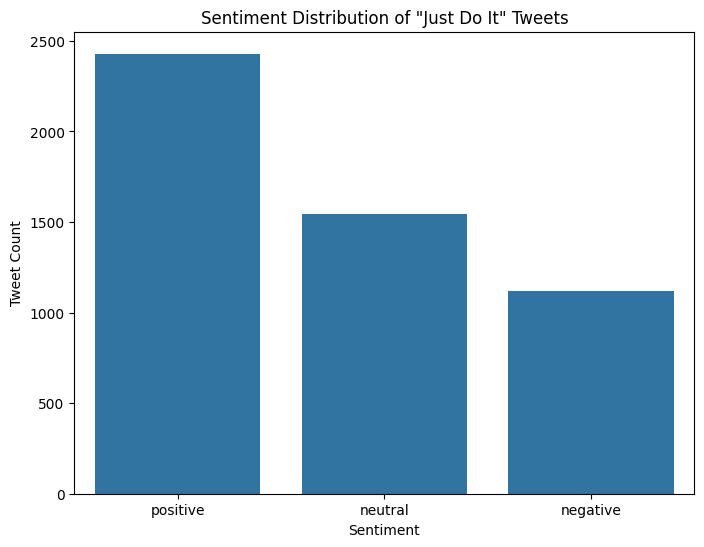

In [12]:
# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution of "Just Do It" Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()

**Topic Modeling using LDA**

In [13]:
# Create a dictionary and corpus required for topic modeling
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(token_list) for token_list in df['tokens']]

In [14]:
# Define the number of topics to extract
num_topics = 5

In [15]:
# Build the LDA model using Gensim
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

In [16]:
# Display the topics with their keywords
print("Extracted Topics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}:")
    print(topic)
    print()

Extracted Topics:
Topic 0:
0.077*"justdoit" + 0.022*"nike" + 0.021*"believe" + 0.019*"even" + 0.016*"something" + 0.013*"everything" + 0.012*"means" + 0.009*"sacrificing" + 0.009*"dont" + 0.007*"like"

Topic 1:
0.056*"justdoit" + 0.011*"football" + 0.010*"nfl" + 0.006*"atlvsphi" + 0.006*"nike" + 0.005*"takeaknee" + 0.004*"music" + 0.004*"stream" + 0.004*"serious" + 0.004*"download"

Topic 2:
0.057*"justdoit" + 0.010*"amp" + 0.009*"nike" + 0.006*"kaepernick" + 0.006*"right" + 0.006*"america" + 0.005*"stand" + 0.005*"great" + 0.004*"love" + 0.003*"history"

Topic 3:
0.083*"justdoit" + 0.025*"nike" + 0.007*"like" + 0.006*"shoes" + 0.006*"get" + 0.005*"takeaknee" + 0.005*"people" + 0.005*"got" + 0.005*"time" + 0.005*"nfl"

Topic 4:
0.102*"justdoit" + 0.059*"nike" + 0.021*"crazy" + 0.016*"commercial" + 0.014*"kaepernick" + 0.014*"ask" + 0.011*"dreams" + 0.011*"dont" + 0.011*"enough" + 0.009*"one"



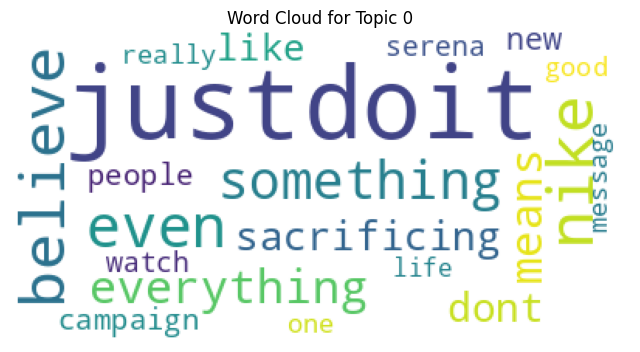

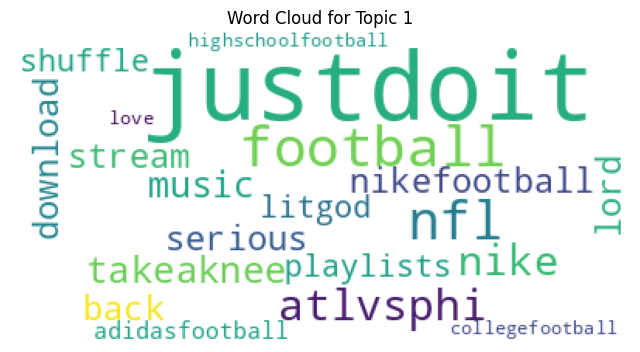

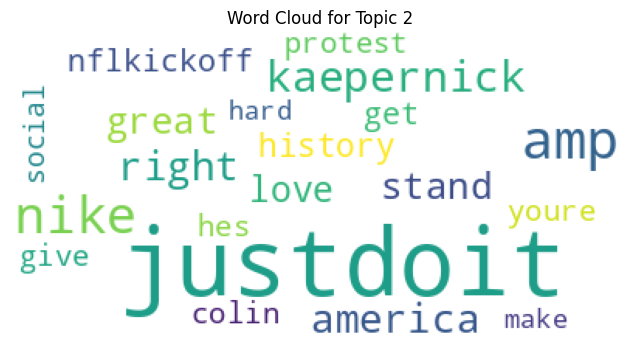

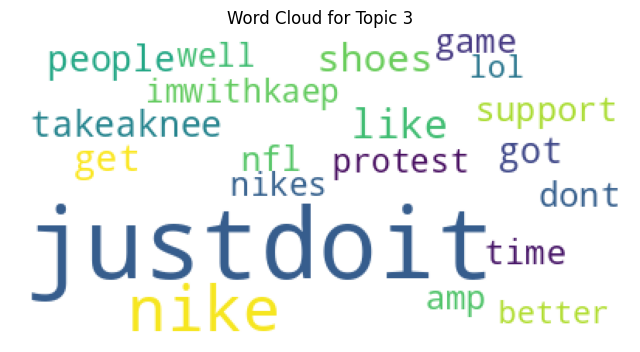

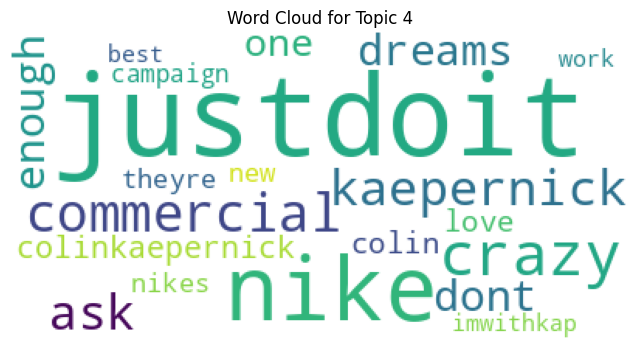

In [17]:
# Generate word clouds for each topic to visualize the key terms
for t in range(num_topics):
    plt.figure(figsize=(8, 6))
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, 20))))
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {t}")
    plt.show()

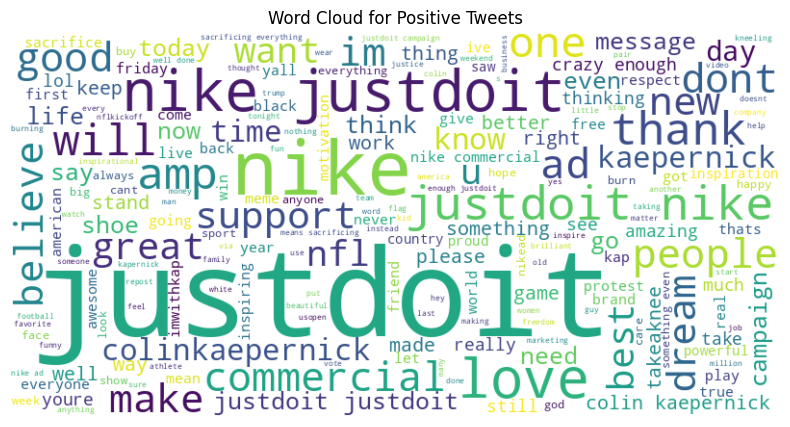

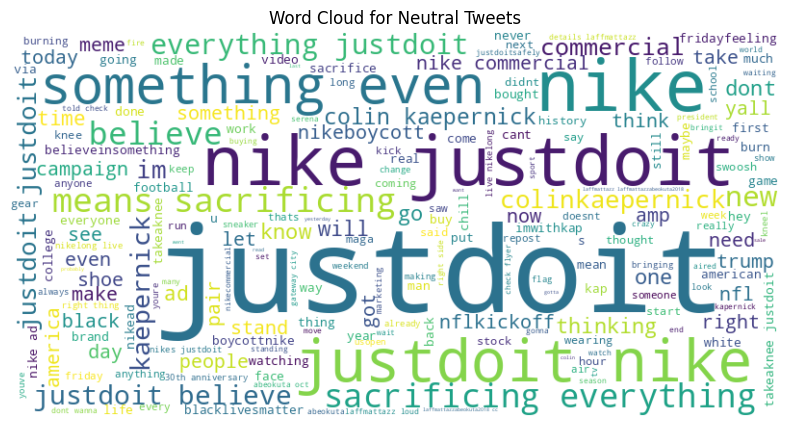

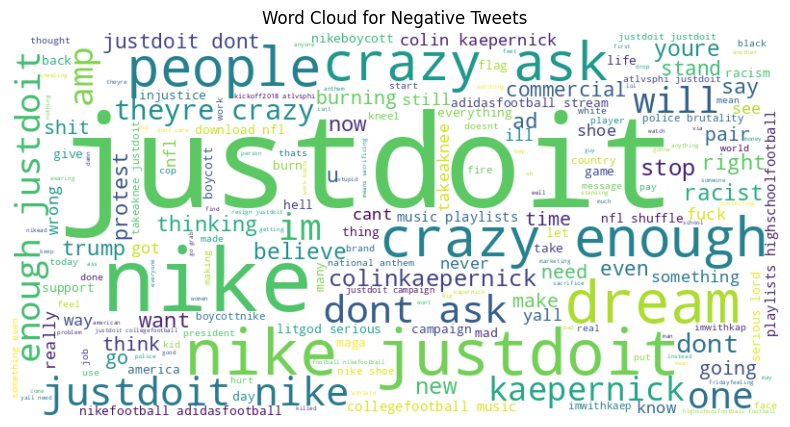

In [18]:
for sentiment in ['positive', 'neutral', 'negative']:
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Tweets')
    plt.show()


In [22]:
print("Sentiment distribution counts:")
print(df['sentiment'].value_counts())


Sentiment distribution counts:
sentiment
positive    2429
neutral     1543
negative    1117
Name: count, dtype: int64


In [21]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(model=lda_model, texts=df['tokens'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')


Coherence Score: 0.3420


Saving and Exporting Results

In [ ]:
# Save the augmented dataset with sentiment results to a new CSV file
df.to_csv('tweets_with_sentiment.csv', index=False)
print("The dataset with sentiment classification has been saved as 'tweets_with_sentiment.csv'.")
